# King County Home Prices

Using regression to predict home prices.

Only limited information is available:<br>
http://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

<br>

In [163]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(font_scale=1.25)

import os, sys
utilpath = os.path.abspath(os.path.join('..', '..', 'mypyutil'))
sys.path.append(utilpath)
from InspectPandas import inspectdata

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

%matplotlib inline

In [164]:
# load and inspect data

df = inspectdata('kc_house_data.csv.zip')
df.head()

Number of records:21,613
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Note:
Looks like the data provided cleaned up the dataset a bit so there aren't any missing values.

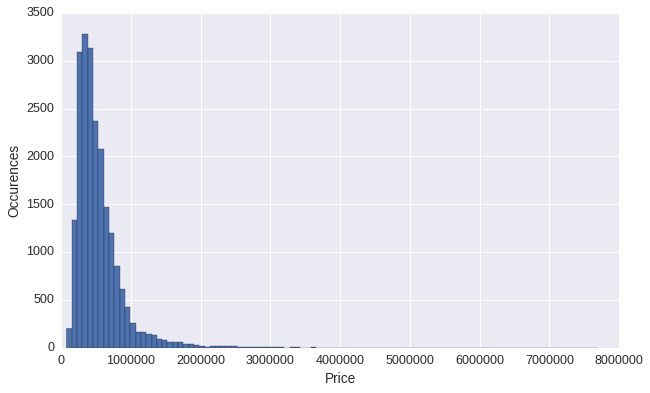

In [22]:
# distribution of prices

plt.figure(figsize=(10,6))
plt.xlabel('Price')
plt.ylabel('Occurences')
_ = df['price'].hist(bins=100)

In [165]:
# what are the categorical variables?

catvars = ['waterfront', 'view', 'condition', 'zipcode']

for var in catvars:
    print('')
    print(var)
    print(df[var].unique())


waterfront
[0 1]

view
[0 3 4 2 1]

condition
[3 5 4 1 2]

zipcode
[98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


### Note:

Based on the possible values, **condition** and **view** are likely ordinal variables. But without more information it is difficult to know with certainty.

**Waterfront** is likely a binary variable indicating if the property is on the waterfront or not, thus does not require encoding or additional processing.

Suggest checking correlation to see if variables are likely imporant.

In [166]:
# summary statistics for each of the variables

df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


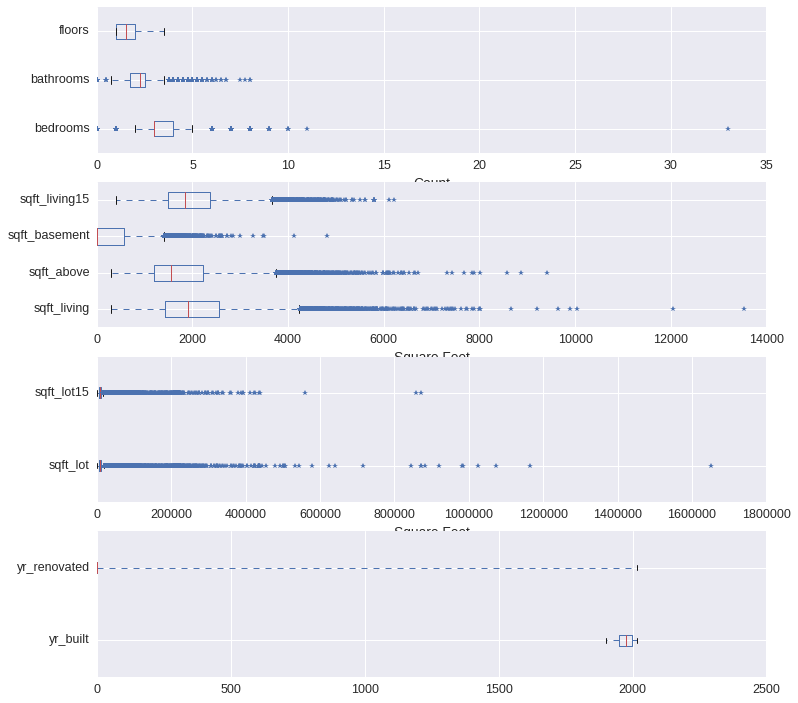

In [167]:
# check for extreme outliers or nonsensical values

f,ax = plt.subplots(4, 1, figsize=(12,12))

df[['bedrooms', 'bathrooms', 'floors']].plot(kind='box', vert=False, sym='*', ax=ax[0])

sqfts = [col for col in df.columns if 'sqft' in col and 'lot' not in col]
df[sqfts].plot(kind='box', vert=False, sym='*', ax=ax[1])

df[[col for col in df.columns if 'sqft' in col and 'lot' in col]].plot(kind='box', vert=False, sym='*', ax=ax[2])

df[[col for col in df.columns if 'yr' in col]].plot(kind='box', vert=False, sym='*', ax=ax[3])

ax[0].set_xlabel('Count')
ax[1].set_xlabel('Square Feet')
ax[2].set_xlabel('Square Feet')

### Note:

Many values for **`yr_renovated`** are zero; the most reasonable interpretation is that these houses were never renovated. Perhaps then, the features with **`15`** indicate the difference between the dimensions of the house in 2015 and as it was originally constructed?

Also 33 bedrooms seems excessive. Perhaps its a typo?

In [ ]:
# exploring the 33 bedrooms

df[df['bedrooms']==33]

In [168]:
# what is the difference in terms of living space and lot size for not renovated houses?

df['livingdiff'] = df['sqft_living15'] - df['sqft_living']
df['lotdiff'] = df['sqft_lot15'] - df['sqft_lot']
df[['livingdiff', 'lotdiff']][df['yr_renovated']==0].describe()

,livingdiff,lotdiff
count,20699.000000,2.069900e+04
mean,-82.317745,-2.316542e+03
std,585.238849,2.912757e+04
min,-8690.000000,-1.225778e+06
25%,-290.000000,-6.700000e+02
50%,0.000000,0.000000e+00
75%,220.000000,4.150000e+02
max,2310.000000,3.268790e+05


In [169]:
# differences for renovated houses?

df[['livingdiff', 'lotdiff']][df['yr_renovated']!=0].describe()

,livingdiff,lotdiff
count,914.000000,914.000000
mean,-343.128009,-2836.050328
std,845.506489,23496.634059
min,-8110.000000,-280213.000000
25%,-780.000000,-1099.000000
50%,-215.000000,0.000000
75%,123.000000,632.000000
max,1960.000000,208216.000000


In [170]:
# do all values with non-zero renovation year, have renovation after year built?

all(df[df['yr_renovated']!=0].index == df[df['yr_renovated']>df['yr_built']].index)

True

In [171]:
# how does the renovation year influence price?

df[['yr_renovated','price']][df['yr_renovated']!=0].corr()

,yr_renovated,price
yr_renovated,1.000000,0.127894
price,0.127894,1.000000


In [172]:
# what about if a renovation is performed?

df['is_renovated'] = df['yr_renovated'].apply(lambda x: int(x>0))
df[['is_renovated', 'price']].corr()

,is_renovated,price
is_renovated,1.000000,0.126092
price,0.126092,1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     15.17
Date:                Wed, 05 Oct 2016   Prob (F-statistic):           0.000106
Time:                        15:52:33   Log-Likelihood:                -13461.
No. Observations:                 914   AIC:                         2.693e+04
Df Residuals:                     912   BIC:                         2.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -9.237e+06   2.57e+06     -3.598      0.000     -1.43e+07  -4.2e+06
yr_renovated  5009.0285   1286.248      3.894      0.000      2484.679  7533.378
==============================================================================
Omnibus:                      880.533   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50308.616
Skew:                           4.306   Prob(JB):                         0.00
Kurtosis:                      38.311   Cond. No.                     2.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

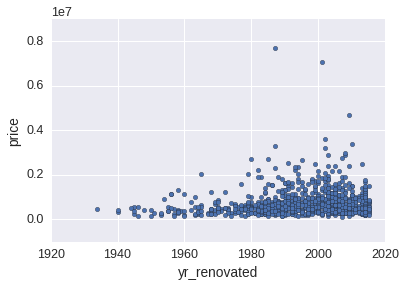

In [173]:
# Is the relationship statistically significant?

dfrenov = df[['yr_renovated', 'price']][df['yr_renovated']!=0]
dfrenov.plot(x='yr_renovated', y='price', kind='scatter')

smf.ols('price ~ yr_renovated', data=dfrenov).fit().summary()

In [174]:
# create new yr_renovated feature where zeros are replaced with NaNs then imputed with the mean

yrmean = df['yr_renovated'][df['yr_renovated']!=0].mean()

def yrreplace(x):
    if x==0:
        return yrmean
    else:
        return x

df['yr_renovated_new'] = df['yr_renovated'].apply(yrreplace)

df['yr_renovated_new'].head()

0    1995.827133
1    1991.000000
2    1995.827133
3    1995.827133
4    1995.827133
Name: yr_renovated_new, dtype: float64

### Note:

1. So the dataset is consistent in that non-zero **`yr_renovation`** values have a renovation date after the build date. 1. The living and lot size can increase or decrease with our without a renovation.
1. There is a moderate correlation between renovation date and price. More recent renovations are correlated with a higher price. Additionally, there is a correlation of the same magnitude between whether or renovation was performed or not.
1. More recent renovations seem to be associated with a higher sale price.

---

# Model with little data processing

Does not include time or location features.

In [176]:
# check for correlation with price for appropriate variables
# drop unexamined variables and any that we can't interpret

exclvars = ['id', 'zipcode', 'lat', 'long', 'date', 'livingdiff', 'lotdiff', 'yr_renovated']

dfcont = df.drop(exclvars, axis=1)

dfcont.corr()[['price']].sort_values(by='price', ascending=False)

,price
price,1.000000
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
bathrooms,0.525138
view,0.397293
sqft_basement,0.323816
bedrooms,0.308350
waterfront,0.266369


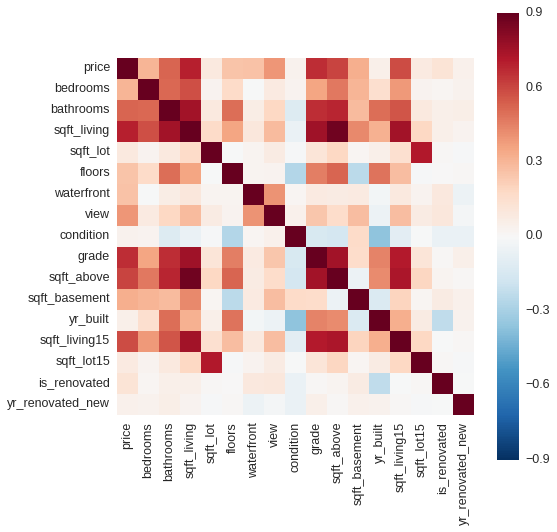

In [177]:
# overall correlation

f, ax = plt.subplots(figsize=(8,8))
_ = sns.heatmap(dfcont.corr(), vmax=0.9, square=True)

In [178]:
# split dataset and standardize

y = dfcont['price']
Xraw = dfcont.drop('price', axis=1)

ss = StandardScaler()
X = ss.fit_transform(Xraw)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [179]:
# ridge regression with standardized values

ridge = RidgeCV(alphas=np.logspace(-5,5,11), cv=None, scoring=None)
ridge.fit(Xtrain, ytrain)

print('alpha = {0:.2g}'.format(ridge.alpha_))
pd.Series(ridge.coef_, index=Xraw.columns).sort_values(ascending=False)

alpha = 1e+02


grade               135526.117987
sqft_living          75194.929868
sqft_above           63807.850489
waterfront           47813.794691
sqft_basement        36656.819711
bathrooms            35919.214543
view                 34434.169738
sqft_living15        18625.608860
floors               14867.767438
condition            11110.946043
yr_renovated_new      9587.116563
is_renovated          5905.176793
sqft_lot             -1424.027122
sqft_lot15          -13712.866570
bedrooms            -35137.884913
yr_built           -103753.527266
dtype: float64

In [180]:
# lasso regression with standardized values

lasso = LassoCV(n_alphas=100, cv=5)
lasso.fit(Xtrain, ytrain)

print('alpha = {0:.2g}'.format(lasso.alpha_))

pd.Series(lasso.coef_, index=Xraw.columns).sort_values(ascending=False)

alpha = 2.5e+02


sqft_living         146327.446694
grade               137458.453197
waterfront           47910.577154
bathrooms            35909.111853
view                 34241.689095
sqft_living15        17351.398005
floors               14367.951231
condition            10620.515539
yr_renovated_new      9320.347967
is_renovated          5397.922097
sqft_basement         2200.838854
sqft_above               0.000000
sqft_lot             -1226.859975
sqft_lot15          -13640.067645
bedrooms            -35105.613811
yr_built           -104810.374965
dtype: float64

In [182]:
# run random forest regressor

rf = RandomForestRegressor(n_jobs=-1)
params = {'n_estimators': [200,300,400,500], 'max_depth': [8,16,24,32]}

grid = GridSearchCV(rf, params, n_jobs=1)
grid.fit(Xtrain, ytrain)
print(grid.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [199]:
griddf = pd.DataFrame(grid.cv_results_)
griddf['mean_test_score'].max()

0.74704523974954684

In [184]:
# run gradient boosting regressor

# gbr = GradientBoostingRegressor()
# params = {'n_estimators': [50,100,150,200], 'max_depth': [4,8,12,16]}

# gridgbr = GridSearchCV(gbr, params, n_jobs=-1)
# gridgbr.fit(Xtrain, ytrain)
# print(gridgbr.best_estimator_)

In [185]:
# gridgbrdf = pd.DataFrame(gridgbr.cv_results_)
# gridgbrdf['mean_test_score'].describe()

In [194]:
# support vector machine regressor

svm = SVR(kernel='rbf')
params = {'C': np.logspace(-1,6,8)}

gridsvm = GridSearchCV(svm, params, scoring='r2', n_jobs=-1)
gridsvm.fit(Xtrain, ytrain)
print(gridsvm.best_estimator_)

SVR(C=1000000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)


In [198]:
griddf = pd.DataFrame(gridsvm.cv_results_)
griddf['mean_test_score'].max()

0.68199441002069938

In [196]:
# compare test set error

regs = [ridge, lasso, grid, gridsvm]
names = ['ridge','lasso', 'random forest', 'svm']

for reg, name in zip(regs, names):
    print(name+' r^2:')
    print('{0:.3}'.format(r2_score(ytest, reg.predict(Xtest))))
    print('')

ridge r^2:
0.66

lasso r^2:
0.66

random forest r^2:
0.729

svm r^2:
0.701



---
# Model including sale time and location

Previously random forest regression proved the best so we will continue with that regressor and see if we can improve the model performance.

In [205]:
# extract year and month from date

df['saleyear'] = pd.to_datetime(df['date']).dt.year
df['salemonth'] = pd.to_datetime(df['date']).dt.month

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,livingdiff,lotdiff,is_renovated,yr_renovated_new,saleyear,salemonth
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,47.5112,-122.257,1340,5650,160,0,0,1995.827133,2014,10
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,47.7210,-122.319,1690,7639,-880,397,1,1991.000000,2014,12
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,47.7379,-122.233,2720,8062,1950,-1938,0,1995.827133,2015,2
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,47.5208,-122.393,1360,5000,-600,0,0,1995.827133,2014,12
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,47.6168,-122.045,1800,7503,120,-577,0,1995.827133,2015,2


In [242]:
# correlation between saleyear, salemonth and price?

df[['saleyear', 'salemonth', 'price']].corr().price

saleyear     0.003576
salemonth   -0.010081
price        1.000000
Name: price, dtype: float64

### Note:
Not strongly correlated as suspected so data should be converted to categorical using dummy variables.

In [240]:
# number of 2014 and 2015 house sales

print('2014 records:', len(dftimeloc[df['saleyear']==2014]))
print('2015 records:', len(dftimeloc[df['saleyear']==2015]))

2014 records: 14633
2015 records: 6980


In [243]:
# are all months present for each year?

print(pd.to_datetime(df['date']).min())
print(pd.to_datetime(df['date']).max())

2014-05-02 00:00:00
2015-05-27 00:00:00


In [247]:
# create dummy variables with pandas for year only since little overlap in 2014 and 2015 months

yr = pd.get_dummies(df['saleyear'], prefix='year')
# month = pd.get_dummies(df['salemonth'], prefix='month')
# df = pd.concat([df, yr, month], axis=1)

#### fix df by removing months

df.columnshttp://localhost:8888/notebooks/Documents/Python/kaggle/kingcountyhomeprices/RegressionHousingPrices1.ipynb#

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'livingdiff', 'lotdiff',
       'is_renovated', 'yr_renovated_new', 'saleyear', 'salemonth',
       'year_2014', 'year_2015', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [248]:
# use lat/long for location since it is more granular than zip code

exclvars = ['id', 'zipcode', 'date', 'livingdiff', 'lotdiff', 'yr_renovated', 'saleyear', 'salemonth']

dftimeloc = df.drop(exclvars, axis=1)
dftimeloc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'is_renovated', 'yr_renovated_new', 'year_2014',
       'year_2015', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

In [249]:
# split dataset and standardize non-categorical variables (standardize categorical variables have any effect?)

y = dftimeloc['price']
Xraw = dftimeloc.drop('price', axis=1)

ss = StandardScaler()
X = ss.fit_transform(Xraw)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=1)

# run random forest regressor

rf2 = RandomForestRegressor(random_state=42, n_jobs=-1)
params = {'n_estimators': [200,300,400,500], 'max_depth': [8,16,24], 'max_features': [0.1,0.25,0.5]}

gridrf2 = GridSearchCV(rf2, params, scoring='r2', n_jobs=1)
gridrf2.fit(Xtrain, ytrain)

# display results

print(gridrf2.best_params_)
griddf = pd.DataFrame(gridrf2.cv_results_)
print('')
print('training set r^2 score = {0:.3f}'.format(griddf['mean_test_score'].max()))

print('')
print('test set r^2 score = {0:.3f}'.format(r2_score(ytest, gridrf2.predict(Xtest))))

{'max_features': 0.5, 'n_estimators': 500, 'max_depth': 24}

training set r^2 score = 0.866

test set r^2 score = 0.860


### Note:

At **`test_size=0.25`** and **`test_size=0.4`** with different random seeds for the train/test split, test error values are very similar.

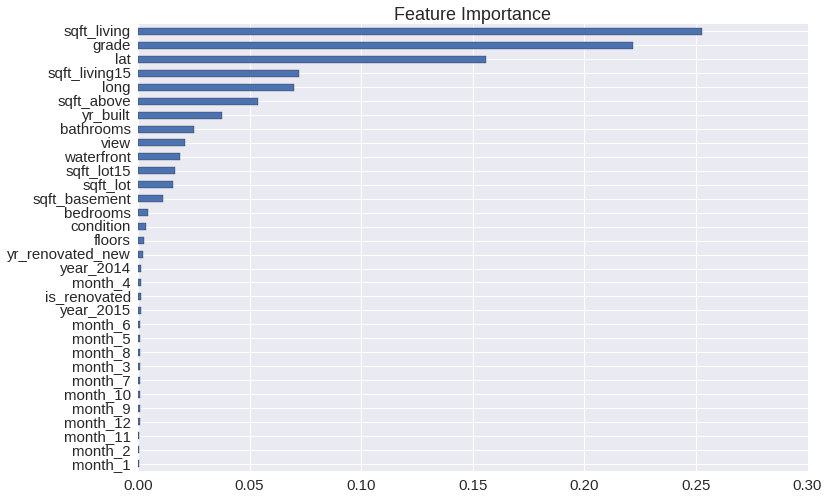

In [250]:
# feature importance

featimp = pd.Series(gridrf2.best_estimator_.feature_importances_, index=Xraw.columns)
plt.figure(figsize=(12,8))
plt.title('Feature Importance')
_ = featimp.sort_values(ascending=True).plot(kind='barh')